<a href="https://colab.research.google.com/github/leonardoub/cmepda/blob/master/brats_classification_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy

#Load data

In [83]:
#load data from Drive
from google.colab import drive
drive.mount('/gdrive')
#%cd /gdrive

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [0]:
dataset_path = '/gdrive/My Drive/BRATS/data_without_NAN_without_HISTO_with_histologies.csv'

In [0]:
df_data = pd.read_csv(dataset_path)

In [86]:
df_data

,ID,Date,VOLUME_ET,VOLUME_NET,VOLUME_ED,VOLUME_TC,VOLUME_WT,VOLUME_BRAIN,VOLUME_ET_OVER_NET,VOLUME_ET_OVER_ED,VOLUME_NET_OVER_ED,VOLUME_ET_over_TC,VOLUME_NET_over_TC,VOLUME_ED_over_TC,VOLUME_ET_OVER_WT,VOLUME_NET_OVER_WT,VOLUME_ED_OVER_WT,VOLUME_TC_OVER_WT,VOLUME_ET_OVER_BRAIN,VOLUME_NET_OVER_BRAIN,VOLUME_ED_over_BRAIN,VOLUME_TC_over_BRAIN,VOLUME_WT_OVER_BRAIN,DIST_Vent_TC,DIST_Vent_ED,INTENSITY_Mean_ET_T1Gd,INTENSITY_STD_ET_T1Gd,INTENSITY_Mean_ET_T1,INTENSITY_STD_ET_T1,INTENSITY_Mean_ET_T2,INTENSITY_STD_ET_T2,INTENSITY_Mean_ET_FLAIR,INTENSITY_STD_ET_FLAIR,INTENSITY_Mean_NET_T1Gd,INTENSITY_STD_NET_T1Gd,INTENSITY_Mean_NET_T1,INTENSITY_STD_NET_T1,INTENSITY_Mean_NET_T2,INTENSITY_STD_NET_T2,INTENSITY_Mean_NET_FLAIR,...,TEXTURE_NGTDM_ED_T1_Busyness,TEXTURE_NGTDM_ED_T1_Complexity,TEXTURE_NGTDM_ED_T1_Strength,TEXTURE_NGTDM_ED_T2_Coarseness,TEXTURE_NGTDM_ED_T2_Contrast,TEXTURE_NGTDM_ED_T2_Busyness,TEXTURE_NGTDM_ED_T2_Complexity,TEXTURE_NGTDM_ED_T2_Strength,TEXTURE_NGTDM_ED_FLAIR_Coarseness,TEXTURE_NGTDM_ED_FLAIR_Contrast,TEXTURE_NGTDM_ED_FLAIR_Busyness,TEXTURE_NGTDM_ED_FLAIR_Complexity,TEXTURE_NGTDM_ED_FLAIR_Strength,TEXTURE_NGTDM_NET_T1Gd_Coarseness,TEXTURE_NGTDM_NET_T1Gd_Contrast,TEXTURE_NGTDM_NET_T1Gd_Busyness,TEXTURE_NGTDM_NET_T1Gd_Complexity,TEXTURE_NGTDM_NET_T1Gd_Strength,TEXTURE_NGTDM_NET_T1_Coarseness,TEXTURE_NGTDM_NET_T1_Contrast,TEXTURE_NGTDM_NET_T1_Busyness,TEXTURE_NGTDM_NET_T1_Complexity,TEXTURE_NGTDM_NET_T1_Strength,TEXTURE_NGTDM_NET_T2_Coarseness,TEXTURE_NGTDM_NET_T2_Contrast,TEXTURE_NGTDM_NET_T2_Busyness,TEXTURE_NGTDM_NET_T2_Complexity,TEXTURE_NGTDM_NET_T2_Strength,TEXTURE_NGTDM_NET_FLAIR_Coarseness,TEXTURE_NGTDM_NET_FLAIR_Contrast,TEXTURE_NGTDM_NET_FLAIR_Busyness,TEXTURE_NGTDM_NET_FLAIR_Complexity,TEXTURE_NGTDM_NET_FLAIR_Strength,TGM_p1,TGM_dw,TGM_Cog_X_1,TGM_Cog_Y_1,TGM_Cog_Z_1,TGM_T_1,Histology
0,TCGA-02-0006,1996.08.23,1662,384,36268,2046,38314,1469432,4.328125,0.045826,0.010588,0.812320,0.187680,17.726300,0.043378,0.010022,0.946599,0.053401,0.001131,0.000261,0.024682,0.001392,0.026074,31.5903,2.7735,149.7977,10.4671,194.1422,15.1037,154.9225,43.4709,220.5894,30.2917,137.8881,6.3820,183.6933,14.8846,161.1005,35.8591,227.7510,...,0.86315,1479.9762,1.10870,0.000605,0.40937,1.47070,2992.2698,0.71642,0.000690,0.28977,1.8815,1872.0528,0.75986,0.026040,0.37869,0.060929,1675.0041,14.11380,0.044156,0.41942,0.026740,2536.7559,43.31290,0.036634,0.50304,0.024264,3593.3279,43.67590,0.057204,0.33980,0.021897,2203.2034,61.32930,8.00000,7.500000e-07,0.178609,0.096256,0.052741,2.00000,GBM
1,TCGA-02-0009,1997.06.14,4362,4349,15723,8711,24434,1295721,1.002989,0.277428,0.276601,0.500750,0.499250,1.805000,0.178522,0.177990,0.643489,0.356511,0.003366,0.003356,0.012135,0.006723,0.018857,9.2443,3.0207,165.4345,6.4047,201.2400,13.4733,113.1601,10.1373,210.1810,15.9543,152.6013,4.2360,188.0607,11.1316,116.8538,10.0992,209.7901,...,0.40004,2378.9184,2.54730,0.000914,0.70926,0.78063,5719.2847,1.29980,0.000882,0.48919,1.8243,2954.8148,0.77199,0.002254,0.29324,1.223600,539.3057,0.53125,0.005712,0.20995,0.315580,967.7845,3.74440,0.003790,0.36163,0.271420,1996.1440,2.77050,0.004966,0.28715,0.189980,1440.4285,3.59990,3.31250,1.000000e-09,0.077618,0.122900,0.094336,91.47360,GBM
2,TCGA-02-0011,1998.02.01,33404,48612,45798,82016,127814,1425843,0.687155,0.729377,1.061444,0.407290,0.592710,0.558400,0.261349,0.380334,0.358318,0.641682,0.023428,0.034094,0.032120,0.057521,0.089641,1.0000,1.0000,186.3385,17.6126,188.2019,23.5195,172.8969,32.7401,167.1395,34.1684,149.0643,12.9090,158.4197,15.2632,197.4966,27.1781,165.1014,...,1.51780,1750.3404,0.56482,0.000382,0.59301,1.81810,4990.3388,0.54747,0.000345,0.59184,2.4243,4703.9458,0.41937,0.000403,0.37863,1.957500,2509.3979,0.42842,0.000768,0.19849,1.395800,1322.6082,0.74730,0.000634,0.31856,1.144300,2517.8629,0.84294,0.000794,0.17961,1.068800,1147.5177,0.80480,5.78125,1.000000e-09,0.132283,0.116006,0.096035,272.42900,GBM
3,TCGA-02-0027,1999.03.28,12114,7587,34086,19701,53787,1403429,1.596679,0.355395,0.222584,

In [372]:
df_data.columns

Index(['ID', 'Date', 'VOLUME_ET', 'VOLUME_NET', 'VOLUME_ED', 'VOLUME_TC',
       'VOLUME_WT', 'VOLUME_BRAIN', 'VOLUME_ET_OVER_NET', 'VOLUME_ET_OVER_ED',
       ...
       'TEXTURE_NGTDM_NET_FLAIR_Busyness',
       'TEXTURE_NGTDM_NET_FLAIR_Complexity',
       'TEXTURE_NGTDM_NET_FLAIR_Strength', 'TGM_p1', 'TGM_dw', 'TGM_Cog_X_1',
       'TGM_Cog_Y_1', 'TGM_Cog_Z_1', 'TGM_T_1', 'Histology'],
      dtype='object', length=587)

In [0]:
data = df_data.drop(['Histology', 'ID', 'Date'], axis=1)

In [0]:
labels = df_data.Histology

#NO K-FOLD

#Train Test Split

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
X_train_big, X_test, y_train_big, y_test = train_test_split(data, labels, test_size=0.2, stratify=labels, random_state=2)

#Train Validation Split

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
X_train, X_val, y_train, y_val = train_test_split(X_train_big, y_train_big, test_size=0.2, stratify=y_train_big, random_state=3)                                                         

In [379]:
X_train.shape

(92, 584)

#Z score dei dati

In [0]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
scaler = MinMaxScaler()
train_data_stand = scaler.fit_transform(X_train)
val_data_stand = scaler.transform(X_val)
test_data_stand = scaler.transform(X_test)

#PCA

In [381]:
from sklearn.decomposition import PCA
pca = PCA(n_components=0.9, svd_solver='full')
pca.fit(train_data_stand)
train_data_stand_pca = pca.transform(train_data_stand)
val_data_stand_pca = pca.transform(val_data_stand)
test_data_stand_pca = pca.transform(test_data_stand)
train_data_stand_pca.shape

(92, 30)

##Z-score dopo PCA

In [0]:
from sklearn.preprocessing import StandardScaler
scaler_2 = MinMaxScaler()
train_data_stand_pca = scaler_2.fit_transform(train_data_stand_pca)
val_data_stand_pca = scaler_2.transform(val_data_stand_pca)
test_data_stand_pca = scaler_2.transform(test_data_stand_pca)

##Vettorizzare i label

In [0]:
word_index={'GBM':0, 'LGG':1}

In [0]:
train_labels_dec = [word_index[label] for label in y_train]

In [0]:
val_labels_dec = [word_index[label] for label in y_val]

In [0]:
test_labels_dec = [word_index[label] for label in y_test]

In [0]:
from keras.utils.np_utils import to_categorical

In [0]:
one_hot_train_labels = to_categorical(train_labels_dec)
one_hot_val_labels = to_categorical(val_labels_dec)
one_hot_test_labels = to_categorical(test_labels_dec)

##Building Network

In [0]:
import keras
from keras import layers
from keras.preprocessing import sequence

In [0]:
from keras import layers

In [0]:
from keras.optimizers import RMSprop
from keras.optimizers import Adagrad
from keras.optimizers import Adadelta
from keras.optimizers import Adam
from keras.optimizers import Adamax
from keras.optimizers import Nadam
from keras.optimizers import SGD

In [0]:
from keras import regularizers

In [0]:
from keras.optimizers import SGD

In [0]:
def build_model():
  model = keras.models.Sequential()
  model.add(layers.Dense(30, activation='relu', input_shape=(30,), kernel_regularizer=regularizers.l2(l=0.005)))
  #model.add(layers.Dropout(0.2))
  #model.add(layers.Dense(30, activation='relu', kernel_regularizer=regularizers.l2(l=0.001)))
  #model.add(layers.Dropout(0.1))

  model.add(layers.Dense(2, activation='sigmoid'))

  sgd = SGD(lr=0.01, momentum=0.9)
  adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)

  model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
  return model

In [0]:
from keras.callbacks import ReduceLROnPlateau
red_lr = ReduceLROnPlateau('val_loss', patience=10, verbose=1, min_lr=0.0001)
#usandolo la loss non scende anche se non agisce, COME MAI????
#non usandolo e non variando nient'altro la loss scende molto rapidamente

In [396]:

one_hot_val_labels.shape

(24, 2)

In [397]:
num_epochs = 500

model = build_model()
history = model.fit(train_data_stand_pca, one_hot_train_labels, validation_data=(val_data_stand_pca, one_hot_val_labels), 
                      epochs= num_epochs, batch_size=92)
  

acc_history = history.history['accuracy']
loss_history = history.history['loss']
acc_val_history = history.history['val_accuracy']
loss_val_history = history.history['val_loss']


Train on 92 samples, validate on 24 samples
Epoch 1/500
92/92 [==============================] - 0s 1ms/step - loss: 0.8018 - accuracy: 0.6902 - val_loss: 0.8329 - val_accuracy: 0.6875
Epoch 2/500
92/92 [==============================] - 0s 70us/step - loss: 0.7987 - accuracy: 0.7011 - val_loss: 0.8296 - val_accuracy: 0.7083
Epoch 3/500
92/92 [==============================] - 0s 59us/step - loss: 0.7953 - accuracy: 0.7011 - val_loss: 0.8263 - val_accuracy: 0.7083
Epoch 4/500
92/92 [==============================] - 0s 61us/step - loss: 0.7919 - accuracy: 0.7011 - val_loss: 0.8230 - val_accuracy: 0.7083
Epoch 5/500
92/92 [==============================] - 0s 33us/step - loss: 0.7885 - accuracy: 0.7011 - val_loss: 0.8198 - val_accuracy: 0.7083
Epoch 6/500
92/92 [==============================] - 0s 53us/step - loss: 0.7853 - accuracy: 0.6957 - val_loss: 0.8166 - val_accuracy: 0.7083
Epoch 7/500
92/92 [==============================] - 0s 49us/step - loss: 0.7822 - accuracy: 0.6957 - val

##Plotting training and validation loss

In [0]:
import matplotlib.pyplot as plt

In [0]:
epochs = range(1, num_epochs+1)

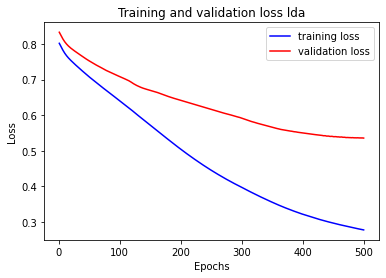

In [398]:
plt.plot(epochs, loss_history, 'b', label='training loss')
plt.plot(epochs, loss_val_history, 'r', label='validation loss')
plt.title('Training and validation loss lda')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

##Plotting train and validation accuracy

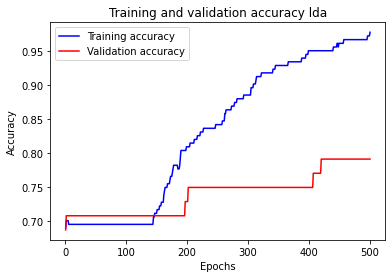

In [399]:
plt.plot(epochs, acc_history, 'b', label='Training accuracy')
plt.plot(epochs, acc_val_history, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy lda')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend() 

##Performances on test set

In [400]:
 model = build_model()
 model.fit(train_data_stand_pca, one_hot_train_labels, epochs= num_epochs, batch_size=92, shuffle=True)
 test_loss, test_acc = model.evaluate(test_data_stand_pca, one_hot_test_labels)
  

Epoch 1/500
92/92 [==============================] - 0s 978us/step - loss: 0.8604 - accuracy: 0.4348
Epoch 2/500
92/92 [==============================] - 0s 25us/step - loss: 0.8534 - accuracy: 0.4565
Epoch 3/500
92/92 [==============================] - 0s 27us/step - loss: 0.8466 - accuracy: 0.4891
Epoch 4/500
92/92 [==============================] - 0s 29us/step - loss: 0.8400 - accuracy: 0.5054
Epoch 5/500
92/92 [==============================] - 0s 24us/step - loss: 0.8337 - accuracy: 0.5326
Epoch 6/500
92/92 [==============================] - 0s 26us/step - loss: 0.8278 - accuracy: 0.5707
Epoch 7/500
92/92 [==============================] - 0s 23us/step - loss: 0.8221 - accuracy: 0.5924
Epoch 8/500
92/92 [==============================] - 0s 21us/step - loss: 0.8165 - accuracy: 0.5978
Epoch 9/500
92/92 [==============================] - 0s 21us/step - loss: 0.8112 - accuracy: 0.6250
Epoch 10/500
92/92 [==============================] - 0s 21us/step - loss: 0.8060 - accuracy: 0.635

In [401]:
model.metrics_names

['loss', 'accuracy']

In [402]:
test_acc


0.8333333134651184

Si comporta molto bene in training e in validation ma si comporta male in test

#SENZA PCA

##Vettorizzare i label

In [0]:
word_index={'GBM':0, 'LGG':1}

In [0]:
train_labels_dec = [word_index[label] for label in y_train]

In [0]:
val_labels_dec = [word_index[label] for label in y_val]

In [0]:
test_labels_dec = [word_index[label] for label in y_test]

In [0]:
from keras.utils.np_utils import to_categorical

In [0]:
one_hot_train_labels = to_categorical(train_labels_dec)
one_hot_val_labels = to_categorical(val_labels_dec)
one_hot_test_labels = to_categorical(test_labels_dec)


In [0]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
train_labels_enc = encoder.fit_transform(y_train)
val_labels_enc = encoder.transform(y_val)
test_labels_enc = encoder.transform(y_test)

##Building Network

In [0]:
import keras
from keras import layers
from keras.preprocessing import sequence

In [0]:
from keras import layers

In [0]:
from keras.optimizers import RMSprop
from keras.optimizers import Adagrad
from keras.optimizers import Adadelta
from keras.optimizers import Adam
from keras.optimizers import Adamax
from keras.optimizers import Nadam
from keras.optimizers import SGD

In [0]:
from keras import regularizers

In [0]:
from keras.optimizers import SGD

In [0]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]


In [0]:
import tensorflow as tf


In [0]:
def build_model():
  model = keras.models.Sequential()
  model.add(layers.Dense(20, activation='relu', input_shape=(584,), kernel_regularizer=regularizers.l2(l=0.05)))
  #model.add(layers.Dropout(0.01))
  #model.add(layers.Dense(10, activation='relu', kernel_regularizer=regularizers.l2(l=0.05)))
  #model.add(layers.Dropout(0.01))

  model.add(layers.Dense(1, activation='sigmoid'))

  sgd = SGD(lr=0.05, momentum=0.9)
  adam = Adam(lr=0.01, beta_1=0.9, beta_2=0.999, amsgrad=False)
  rmsprop = RMSprop(lr=0.001)

  model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
  return model

In [0]:
from keras.callbacks import ReduceLROnPlateau
red_lr = ReduceLROnPlateau('val_loss', patience=10, verbose=1, factor=0.1, min_lr=0.0001)
#usandolo la loss non scende anche se non agisce, COME MAI????
#non usandolo e non variando nient'altro la loss scende molto rapidamente

In [413]:

one_hot_val_labels.shape

(24, 2)

In [414]:
num_epochs = 500

model = build_model()
history = model.fit(train_data_stand, train_labels_enc, validation_data=(val_data_stand, val_labels_enc), 
                      epochs= num_epochs, batch_size=92, callbacks=[red_lr])
  

acc_history = history.history['accuracy']
loss_history = history.history['loss']
acc_val_history = history.history['val_accuracy']
loss_val_history = history.history['val_loss']


Train on 92 samples, validate on 24 samples
Epoch 1/500
92/92 [==============================] - 0s 1ms/step - loss: 2.7233 - accuracy: 0.2826 - val_loss: 2.5479 - val_accuracy: 0.7083
Epoch 2/500
92/92 [==============================] - 0s 53us/step - loss: 2.6221 - accuracy: 0.6957 - val_loss: 2.0510 - val_accuracy: 0.7083
Epoch 3/500
92/92 [==============================] - 0s 83us/step - loss: 2.0740 - accuracy: 0.6957 - val_loss: 1.7524 - val_accuracy: 0.8333
Epoch 4/500
92/92 [==============================] - 0s 53us/step - loss: 1.7453 - accuracy: 0.8696 - val_loss: 1.5144 - val_accuracy: 0.8333
Epoch 5/500
92/92 [==============================] - 0s 49us/step - loss: 1.4941 - accuracy: 0.8587 - val_loss: 1.3304 - val_accuracy: 0.7917
Epoch 6/500
92/92 [==============================] - 0s 45us/step - loss: 1.2886 - accuracy: 0.7717 - val_loss: 1.2119 - val_accuracy: 0.7917
Epoch 7/500
92/92 [==============================] - 0s 50us/step - loss: 1.1510 - accuracy: 0.7609 - val

##Plotting training and validation loss

In [0]:
import matplotlib.pyplot as plt

In [0]:
epochs = range(1, num_epochs+1)

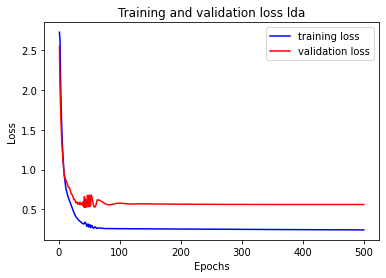

In [416]:
plt.plot(epochs, loss_history, 'b', label='training loss')
plt.plot(epochs, loss_val_history, 'r', label='validation loss')
plt.title('Training and validation loss lda')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

##Plotting train and validation accuracy

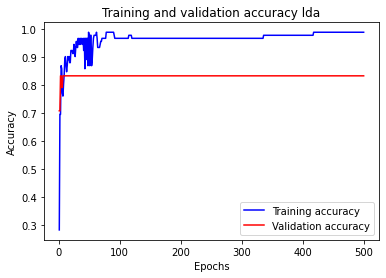

In [417]:
plt.plot(epochs, acc_history, 'b', label='Training accuracy')
plt.plot(epochs, acc_val_history, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy lda')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend() 

##Performances on test set

In [419]:
 model = build_model()
 model.fit(train_data_stand, train_labels_dec, epochs= num_epochs, batch_size=92, shuffle=True)
 test_loss, test_acc = model.evaluate(test_data_stand, test_labels_dec)
  

Epoch 1/500
92/92 [==============================] - 0s 891us/step - loss: 2.5823 - accuracy: 0.6522
Epoch 2/500
92/92 [==============================] - 0s 41us/step - loss: 2.5669 - accuracy: 0.6957
Epoch 3/500
92/92 [==============================] - 0s 27us/step - loss: 1.9312 - accuracy: 0.8152
Epoch 4/500
92/92 [==============================] - 0s 27us/step - loss: 1.9614 - accuracy: 0.4457
Epoch 5/500
92/92 [==============================] - 0s 34us/step - loss: 1.4493 - accuracy: 0.8370
Epoch 6/500
92/92 [==============================] - 0s 29us/step - loss: 1.4102 - accuracy: 0.7609
Epoch 7/500
92/92 [==============================] - 0s 30us/step - loss: 1.2656 - accuracy: 0.7609
Epoch 8/500
92/92 [==============================] - 0s 26us/step - loss: 1.0231 - accuracy: 0.8152
Epoch 9/500
92/92 [==============================] - 0s 27us/step - loss: 0.9557 - accuracy: 0.9130
Epoch 10/500
92/92 [==============================] - 0s 27us/step - loss: 0.9590 - accuracy: 0.847

In [0]:
model.metrics_names

['loss', 'accuracy']

In [420]:
test_acc


0.9333333373069763

Si comporta molto bene in training e in validation ma si comporta male in test

#SELEKT FEATURES PEARSON CORRELATION, È UNSUPERVISED QUINDI NON INTRODUCO BIAS

In [0]:
# Create correlation matrix
corr_matrix = data.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

In [327]:
len(to_drop)


206

In [0]:
# Drop features 
data_reduced=data.drop(data[to_drop], axis=1)

In [330]:
data_reduced

,VOLUME_ET,VOLUME_NET,VOLUME_ED,VOLUME_TC,VOLUME_WT,VOLUME_BRAIN,VOLUME_ET_OVER_NET,VOLUME_ET_OVER_ED,VOLUME_NET_OVER_ED,VOLUME_ET_over_TC,VOLUME_ED_over_TC,VOLUME_ET_OVER_WT,VOLUME_NET_OVER_WT,VOLUME_ED_OVER_WT,DIST_Vent_TC,DIST_Vent_ED,INTENSITY_Mean_ET_T1Gd,INTENSITY_STD_ET_T1Gd,INTENSITY_Mean_ET_T1,INTENSITY_STD_ET_T1,INTENSITY_Mean_ET_T2,INTENSITY_STD_ET_T2,INTENSITY_Mean_ET_FLAIR,INTENSITY_STD_ET_FLAIR,INTENSITY_Mean_NET_T1Gd,INTENSITY_STD_NET_T1Gd,INTENSITY_Mean_NET_T1,INTENSITY_STD_NET_T1,INTENSITY_Mean_NET_T2,INTENSITY_STD_NET_T2,INTENSITY_Mean_NET_FLAIR,INTENSITY_STD_NET_FLAIR,INTENSITY_Mean_ED_T1Gd,INTENSITY_STD_ED_T1Gd,INTENSITY_Mean_ED_T1,INTENSITY_STD_ED_T1,INTENSITY_Mean_ED_T2,INTENSITY_STD_ED_T2,INTENSITY_Mean_ED_FLAIR,INTENSITY_STD_ED_FLAIR,...,TEXTURE_NGTDM_ET_T1_Contrast,TEXTURE_NGTDM_ET_T1_Busyness,TEXTURE_NGTDM_ET_T1_Strength,TEXTURE_NGTDM_ET_T2_Contrast,TEXTURE_NGTDM_ET_T2_Busyness,TEXTURE_NGTDM_ET_T2_Complexity,TEXTURE_NGTDM_ET_T2_Strength,TEXTURE_NGTDM_ET_FLAIR_Contrast,TEXTURE_NGTDM_ET_FLAIR_Busyness,TEXTURE_NGTDM_ET_FLAIR_Complexity,TEXTURE_NGTDM_ET_FLAIR_Strength,TEXTURE_NGTDM_ED_T1Gd_Coarseness,TEXTURE_NGTDM_ED_T1Gd_Busyness,TEXTURE_NGTDM_ED_T1Gd_Strength,TEXTURE_NGTDM_ED_T1_Coarseness,TEXTURE_NGTDM_ED_T1_Busyness,TEXTURE_NGTDM_ED_T1_Strength,TEXTURE_NGTDM_ED_T2_Coarseness,TEXTURE_NGTDM_ED_T2_Busyness,TEXTURE_NGTDM_ED_FLAIR_Coarseness,TEXTURE_NGTDM_ED_FLAIR_Busyness,TEXTURE_NGTDM_ED_FLAIR_Strength,TEXTURE_NGTDM_NET_T1Gd_Busyness,TEXTURE_NGTDM_NET_T1Gd_Strength,TEXTURE_NGTDM_NET_T1_Coarseness,TEXTURE_NGTDM_NET_T1_Busyness,TEXTURE_NGTDM_NET_T1_Strength,TEXTURE_NGTDM_NET_T2_Busyness,TEXTURE_NGTDM_NET_T2_Complexity,TEXTURE_NGTDM_NET_T2_Strength,TEXTURE_NGTDM_NET_FLAIR_Coarseness,TEXTURE_NGTDM_NET_FLAIR_Contrast,TEXTURE_NGTDM_NET_FLAIR_Complexity,TEXTURE_NGTDM_NET_FLAIR_Strength,TGM_p1,TGM_dw,TGM_Cog_X_1,TGM_Cog_Y_1,TGM_Cog_Z_1,TGM_T_1
0,1662,384,36268,2046,38314,1469432,4.328125,0.045826,0.010588,0.812320,17.726300,0.043378,0.010022,0.946599,31.5903,2.7735,149.7977,10.4671,194.1422,15.1037,154.9225,43.4709,220.5894,30.2917,137.8881,6.3820,183.6933,14.8846,161.1005,35.8591,227.7510,23.9509,131.8402,8.0213,188.7259,15.9249,112.7128,18.5509,171.7623,28.2802,...,0.36966,0.066484,13.51700,0.61118,0.095961,4668.4405,11.62680,0.49151,0.083098,3640.7448,13.7035,0.000849,1.33550,0.65599,0.000988,0.86315,1.10870,0.000605,1.47070,0.000690,1.8815,0.75986,0.060929,14.11380,0.044156,0.026740,43.31290,0.024264,3593.3279,43.67590,0.057204,0.33980,2203.2034,61.32930,8.00000,7.500000e-07,0.178609,0.096256,0.052741,2.00000
1,4362,4349,15723,8711,24434,1295721,1.002989,0.277428,0.276601,0.500750,1.805000,0.178522,0.177990,0.643489,9.2443,3.0207,165.4345,6.4047,201.2400,13.4733,113.1601,10.1373,210.1810,15.9543,152.6013,4.2360,188.0607,11.1316,116.8538,10.0992,209.7901,16.7943,139.2815,11.7893,189.7841,22.8683,109.9477,18.6668,190.0843,19.1663,...,0.18462,0.154740,6.90060,0.47885,0.179650,3378.9729,4.70500,0.24995,0.205790,1306.2095,3.7181,0.001926,0.54351,1.99800,0.001869,0.40004,2.54730,0.000914,0.78063,0.000882,1.8243,0.77199,1.223600,0.53125,0.005712,0.315580,3.74440,0.271420,1996.1440,2.77050,0.004966,0.28715,1440.4285,3.59990,3.31250,1.000000e-09,0.077618,0.122900,0.094336,91.47360
2,33404,48612,45798,82016,127814,1425843,0.687155,0.729377,1.061444,0.407290,0.558400,0.261349,0.380334,0.358318,1.0000,1.0000,186.3385,17.6126,188.2019,23.5195,172.8969,32.7401,167.1395,34.1684,149.0643,12.9090,158.4197,15.2632,197.4966,27.1781,165.1014,25.2120,161.5790,14.7441,184.1934,20.4879,126.6645,35.5877,116.7452,18.9931,...,0.26313,0.992810,1.05600,0.46056,1.149400,3627.2679,0.83550,0.31288,0.897080,2402.4765,1.0795,0.000514,2.40570,0.33032,0.000571,1.51780,0.56482,0.000382,1.81810,0.000345,2.4243,0.41937,1.957500,0.42842,0.000768,1.395800,0.74730,1.144300,2517.8629,0.84294,0.000794,0.17961,1147.5177,0.80480,5.78125,1.000000e-09,0.132283,0.116006,0.096035,272.42900
3,12114,7587,34086,19701,53787,1403429,1.596679,0.355395,0.222584,0

##Train Test Split

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
X_train_big, X_test, y_train_big, y_test = train_test_split(data_reduced, labels, test_size=0.2, stratify=labels, random_state=2)

##Train Validation Split

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
X_train, X_val, y_train, y_val = train_test_split(X_train_big, y_train_big, test_size=0.2, stratify=y_train_big, random_state=3)                                                         

In [343]:
X_train.shape

(92, 378)

#Z score dei dati

In [0]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
scaler = MinMaxScaler()
train_data_stand = scaler.fit_transform(X_train)
val_data_stand = scaler.transform(X_val)
test_data_stand = scaler.transform(X_test)

##SENZA PCA

##Vettorizzare i label

In [0]:
word_index={'GBM':0, 'LGG':1}

In [0]:
train_labels_dec = [word_index[label] for label in y_train]

In [0]:
val_labels_dec = [word_index[label] for label in y_val]

In [0]:
test_labels_dec = [word_index[label] for label in y_test]

In [0]:
from keras.utils.np_utils import to_categorical

In [0]:
one_hot_train_labels = to_categorical(train_labels_dec)
one_hot_val_labels = to_categorical(val_labels_dec)
one_hot_test_labels = to_categorical(test_labels_dec)


In [0]:
from sklearn.preprocessing import LabelEncoder

In [0]:
encoder = LabelEncoder()
train_labels_enc = encoder.fit_transform(y_train)
val_labels_enc = encoder.transform(y_val)
test_labels_enc = encoder.transform(y_test)

##Building Network

In [0]:
import keras
from keras import layers
from keras.preprocessing import sequence

In [0]:
from keras import layers

In [0]:
from keras.optimizers import RMSprop
from keras.optimizers import Adagrad
from keras.optimizers import Adadelta
from keras.optimizers import Adam
from keras.optimizers import Adamax
from keras.optimizers import Nadam
from keras.optimizers import SGD

In [0]:
from keras import regularizers

In [0]:
from keras.optimizers import SGD

In [0]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]


In [0]:
import tensorflow as tf


In [0]:
def build_model():
  model = keras.models.Sequential()
  model.add(layers.Dense(20, activation='relu', input_shape=(378,), kernel_regularizer=regularizers.l2(l=0.05)))
  #model.add(layers.Dropout(0.01))
  #model.add(layers.Dense(10, activation='relu', kernel_regularizer=regularizers.l2(l=0.05)))
  #model.add(layers.Dropout(0.01))

  model.add(layers.Dense(1, activation='sigmoid'))

  sgd = SGD(lr=0.05, momentum=0.9)
  adam = Adam(lr=0.01, beta_1=0.9, beta_2=0.999, amsgrad=False)
  rmsprop = RMSprop(lr=0.001)

  model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
  return model

In [0]:
from keras.callbacks import ReduceLROnPlateau
red_lr = ReduceLROnPlateau('val_loss', patience=10, verbose=1, factor=0.1, min_lr=0.0001)
#usandolo la loss non scende anche se non agisce, COME MAI????
#non usandolo e non variando nient'altro la loss scende molto rapidamente

In [363]:

one_hot_val_labels.shape

(24, 2)

In [364]:
num_epochs = 500

model = build_model()
history = model.fit(train_data_stand, train_labels_enc, validation_data=(val_data_stand, val_labels_enc), 
                      epochs= num_epochs, batch_size=92, callbacks=[red_lr])
  

acc_history = history.history['accuracy']
loss_history = history.history['loss']
acc_val_history = history.history['val_accuracy']
loss_val_history = history.history['val_loss']


Train on 92 samples, validate on 24 samples
Epoch 1/500
92/92 [==============================] - 0s 1ms/step - loss: 2.6359 - accuracy: 0.3587 - val_loss: 2.3241 - val_accuracy: 0.7083
Epoch 2/500
92/92 [==============================] - 0s 49us/step - loss: 2.3220 - accuracy: 0.6957 - val_loss: 2.0399 - val_accuracy: 0.7083
Epoch 3/500
92/92 [==============================] - 0s 43us/step - loss: 2.0297 - accuracy: 0.6957 - val_loss: 1.7484 - val_accuracy: 0.7500
Epoch 4/500
92/92 [==============================] - 0s 40us/step - loss: 1.7278 - accuracy: 0.7935 - val_loss: 1.5541 - val_accuracy: 0.8750
Epoch 5/500
92/92 [==============================] - 0s 42us/step - loss: 1.5324 - accuracy: 0.8913 - val_loss: 1.3190 - val_accuracy: 0.8333
Epoch 6/500
92/92 [==============================] - 0s 42us/step - loss: 1.2812 - accuracy: 0.8261 - val_loss: 1.1688 - val_accuracy: 0.7917
Epoch 7/500
92/92 [==============================] - 0s 42us/step - loss: 1.1082 - accuracy: 0.7935 - val

##Plotting training and validation loss

In [0]:
import matplotlib.pyplot as plt

In [0]:
epochs = range(1, num_epochs+1)

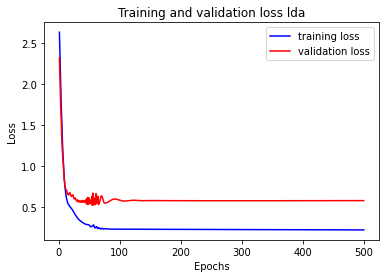

In [368]:
plt.plot(epochs, loss_history, 'b', label='training loss')
plt.plot(epochs, loss_val_history, 'r', label='validation loss')
plt.title('Training and validation loss lda')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

##Plotting train and validation accuracy

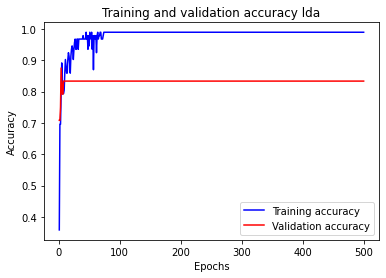

In [369]:
plt.plot(epochs, acc_history, 'b', label='Training accuracy')
plt.plot(epochs, acc_val_history, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy lda')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend() 

##Performances on test set

In [370]:
 model = build_model()
 model.fit(train_data_stand, train_labels_dec, epochs= num_epochs, batch_size=92, shuffle=True)
 test_loss, test_acc = model.evaluate(test_data_stand, test_labels_enc)
  

Epoch 1/500
92/92 [==============================] - 0s 1ms/step - loss: 2.7087 - accuracy: 0.2065
Epoch 2/500
92/92 [==============================] - 0s 60us/step - loss: 2.2928 - accuracy: 0.6957
Epoch 3/500
92/92 [==============================] - 0s 47us/step - loss: 1.9988 - accuracy: 0.6957
Epoch 4/500
92/92 [==============================] - 0s 46us/step - loss: 1.6924 - accuracy: 0.7065
Epoch 5/500
92/92 [==============================] - 0s 27us/step - loss: 1.4962 - accuracy: 0.8152
Epoch 6/500
92/92 [==============================] - 0s 29us/step - loss: 1.2766 - accuracy: 0.7717
Epoch 7/500
92/92 [==============================] - 0s 24us/step - loss: 1.1119 - accuracy: 0.7500
Epoch 8/500
92/92 [==============================] - 0s 21us/step - loss: 0.9851 - accuracy: 0.7717
Epoch 9/500
92/92 [==============================] - 0s 23us/step - loss: 0.8688 - accuracy: 0.8152
Epoch 10/500
92/92 [==============================] - 0s 26us/step - loss: 0.7849 - accuracy: 0.8587


In [0]:
model.metrics_names

['loss', 'accuracy']

In [371]:
test_acc


0.9333333373069763

Si comporta molto bene in training e in validation ma si comporta male in test